In [2]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [3]:
# To download and use the Washington DC image:
#hsi_data.download('WashingtonDC')
#fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
hsi_data.download('MicroscenePolymers')
fname = 'spectral_images/Microscene_Polymers/reflectance_image_polymers'

In [4]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (852, 384, 452)
Shape of imList = (327168, 452)


In [5]:
# load the associated ground truth image
fname = 'ground_truth_images/reflectance_image_polymers_surfaces.txt'
file1 = open(fname, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: surge_protector_hard
Index: 0
Number of points: 1501
 
Name: ping_pong_ball
Index: 1
Number of points: 320
 
Name: red_lid
Index: 2
Number of points: 7371
 
Name: medicine_bottle_cap
Index: 3
Number of points: 252
 
Name: plastic_bottle
Index: 4
Number of points: 2862
 
Name: red_bubble_wrap
Index: 5
Number of points: 16756
 
Name: clear_bubble_wrap
Index: 6
Number of points: 9997
 
Name: PVC_plumbing_pipe
Index: 7
Number of points: 6765
 
Name: polymer_football
Index: 8
Number of points: 5503
 
Name: gloave
Index: 9
Number of points: 2759
 
Name: foil_bag
Index: 10
Number of points: 7807
 
Name: foam_packaging
Index: 11
Number of points: 21831
 


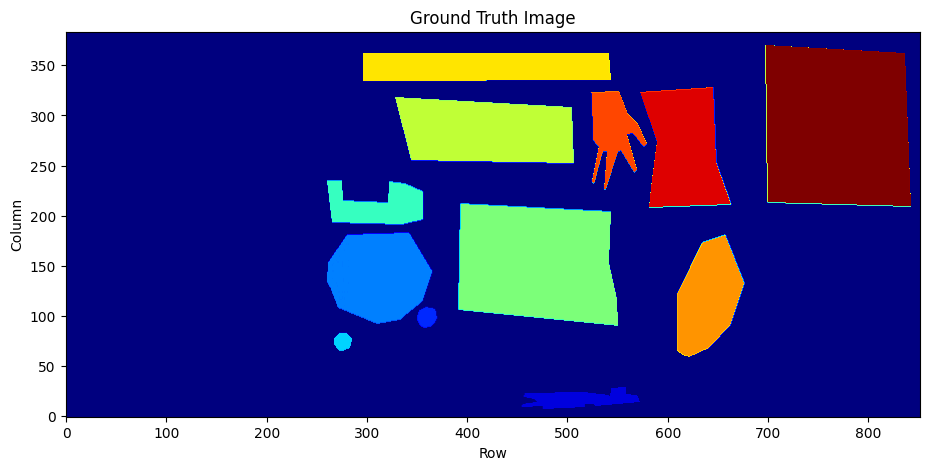

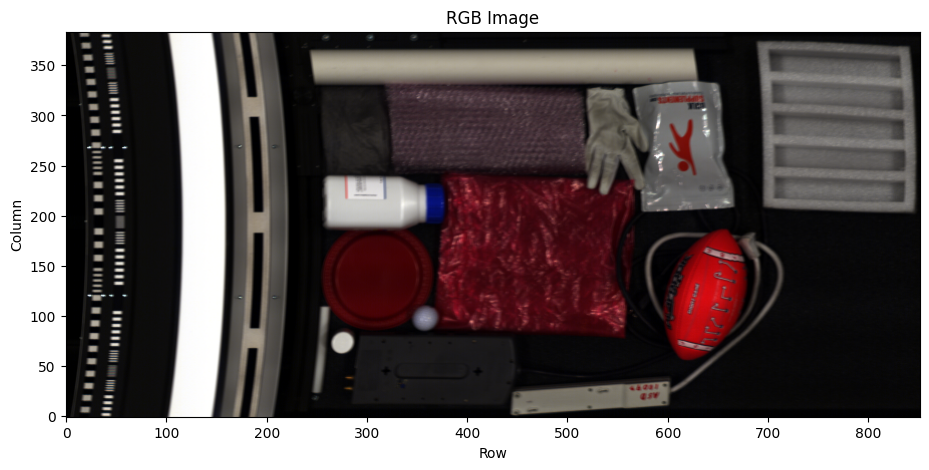

In [6]:
plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

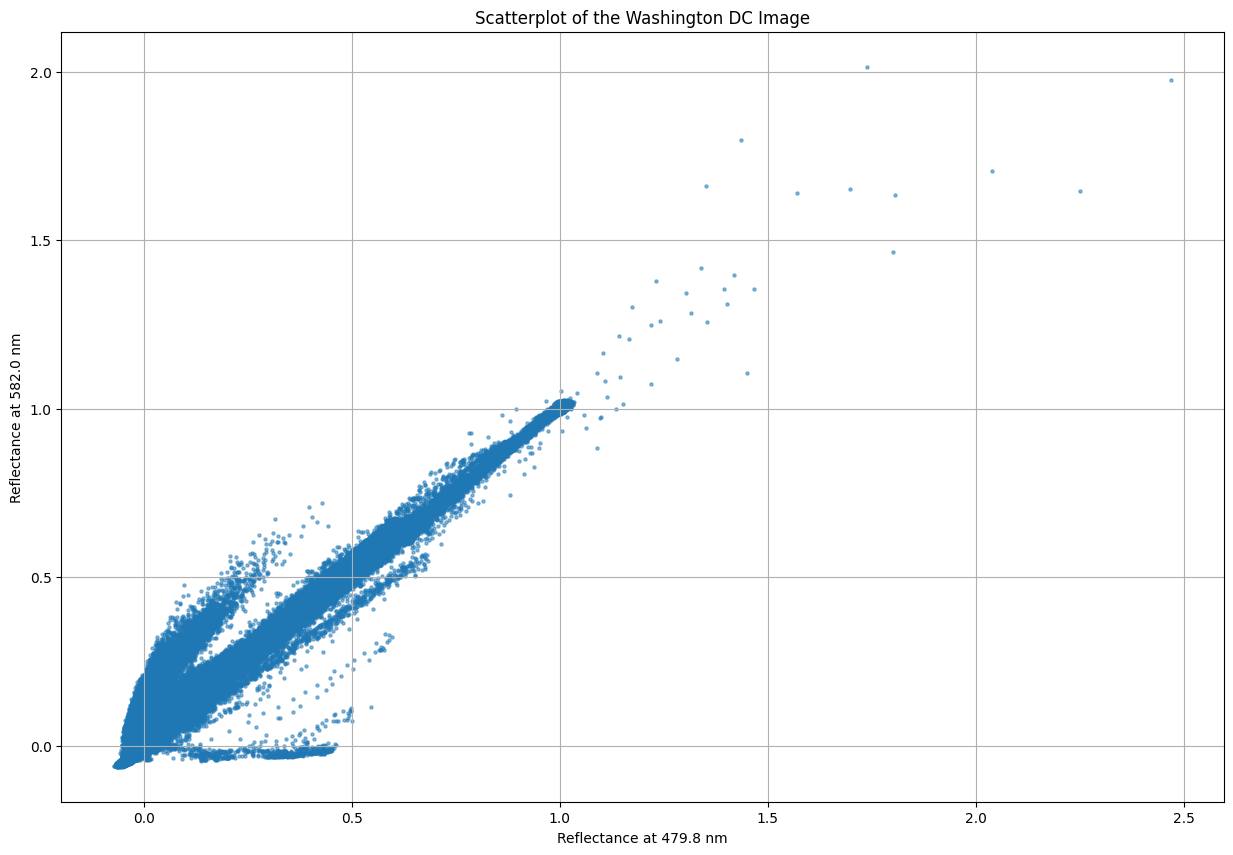

In [7]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

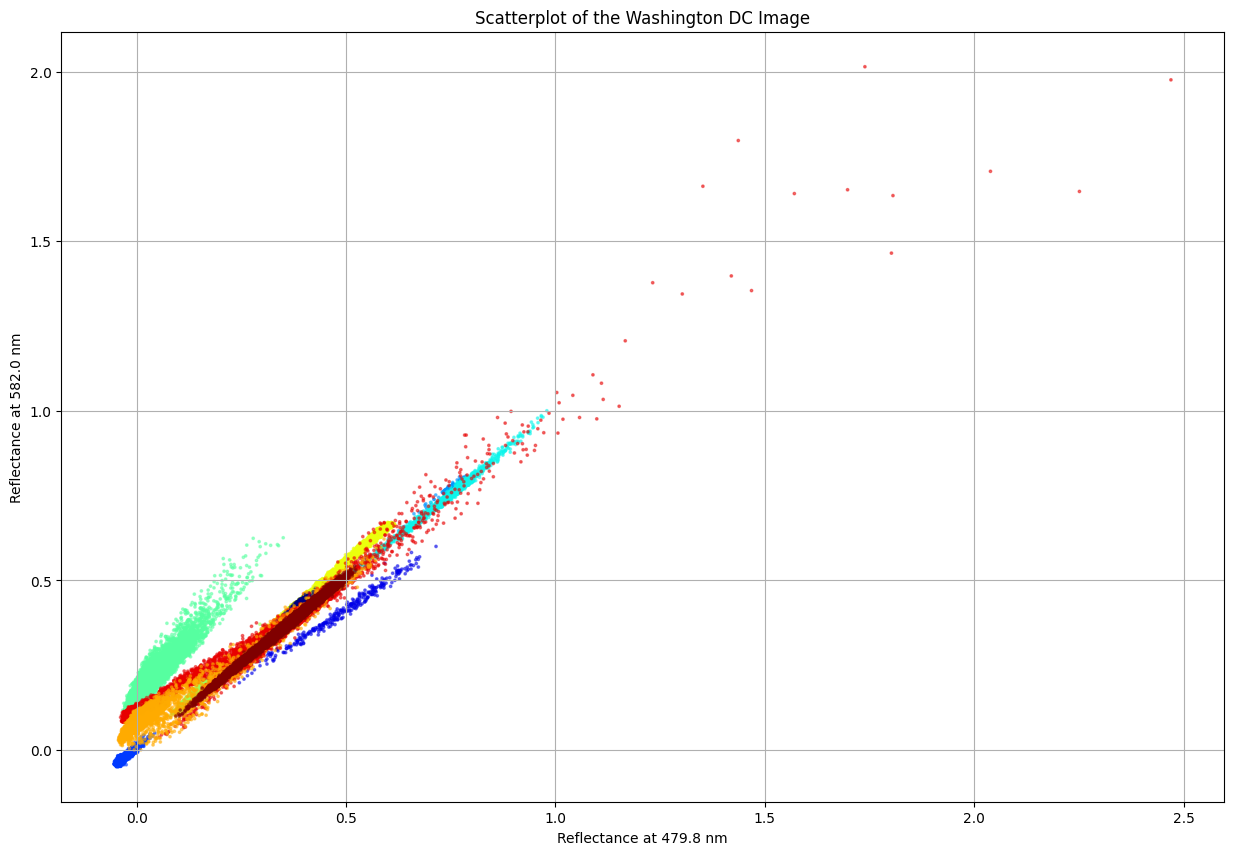

In [8]:
# Create a scatterplot of the data, colored by groundtruth class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
gt_indiexes = np.where(gt_list>0)[0] # get hte indices only for pixels in ground truth classes
plt.scatter(imList[gt_indiexes,i1], imList[gt_indiexes,i2], c=gt_list[gt_indiexes], s=3, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Examining Individual Classes

In [9]:
groundtruth_classes.keys()

dict_keys(['surge_protector_hard', 'ping_pong_ball', 'red_lid', 'medicine_bottle_cap', 'plastic_bottle', 'red_bubble_wrap', 'clear_bubble_wrap', 'PVC_plumbing_pipe', 'polymer_football', 'gloave', 'foil_bag', 'foam_packaging'])

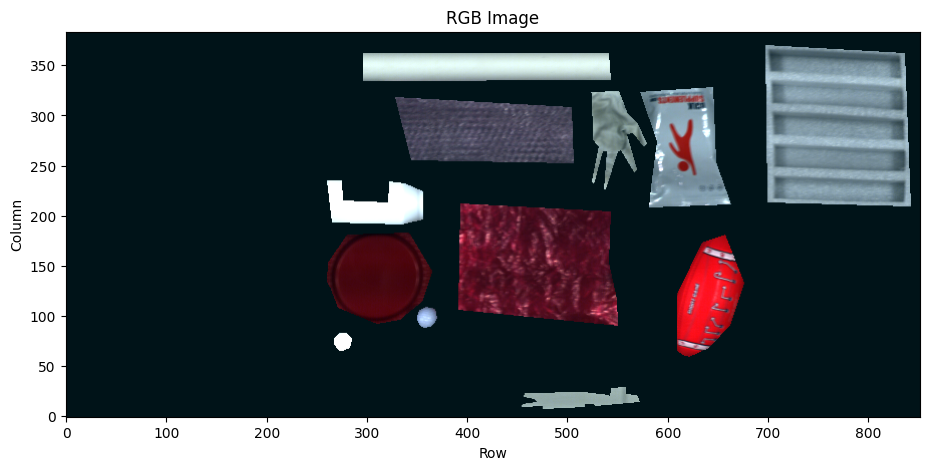

In [10]:
class_only_image = np.zeros((im.nrows, im.ncols, im.nbands))
for class_name in groundtruth_classes.keys():
    for x,y in groundtruth_classes[class_name]['locations']:
        class_only_image[int(x), int(y), :] = imArr[int(x), int(y), :]

sm2.display_RGB(class_only_image, wl, stretch_pct=[0,99], rotate=True)
plt.title('RGB Image');

## SLOW computation method:

In [11]:
nClasses = len(groundtruth_classes.keys())

want_to_waste_time = False
if want_to_waste_time:
    class_means = np.zeros((nClasses, im.nbands))
    C = np.zeros((im.nbands,im.nbands))

    # Compute means
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        for x,y in groundtruth_classes[class_name]['locations']:
            # add to computation of class means
            spec = imArr[int(x), int(y), :].flatten()
            class_means[class_idx,:] = class_means[class_idx,:] + spec

    num_pixels_all_classes = 0
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        num_pixels_in_class = len(groundtruth_classes[class_name]['locations'])
        num_pixels_all_classes = num_pixels_all_classes + num_pixels_in_class
        class_means[class_idx,:] = class_means[class_idx,:]/num_pixels_in_class


    # Compute class covariance (assuming all classes have the same covariance - LDA)
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        for x,y in groundtruth_classes[class_name]['locations']:
            # add to computation of covariance
            spec = imArr[int(x), int(y), :].flatten()
            x_minus_mean = np.reshape((spec-class_means[class_idx,:]), (im.nbands,1))
            C = C + np.matmul(x_minus_mean, x_minus_mean.T)
            
    C = C / num_pixels_all_classes
         

Individual class covariance:

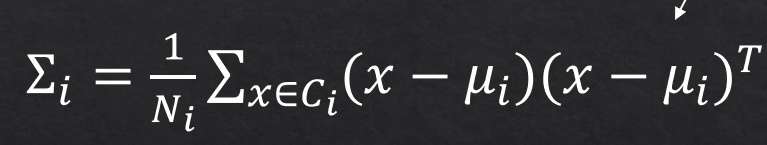

The LDA single covariance is computed using either of the following:

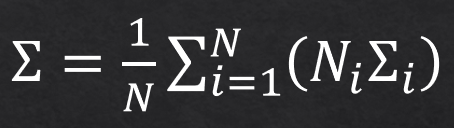

or

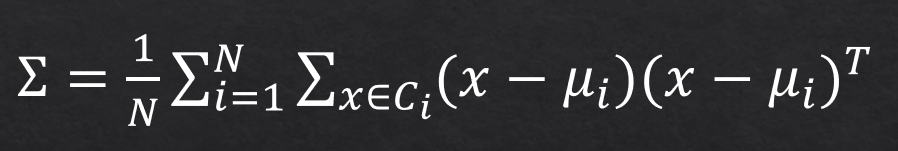

##  MUCH FASTER Computation using numpy:

In [12]:
class_means = np.zeros((nClasses, im.nbands))
class_covariances = np.zeros((nClasses, im.nbands, im.nbands))
C = np.zeros((im.nbands,im.nbands))

class_indices = np.unique(gt_list).astype(int)
for idx in class_indices:
    # skip idx==0 because that corresponds to the unlabeled (background) class
    if idx > 0: 
        class_locations = np.where(gt_list==idx)[0]
        num_class_spectra = len(class_locations) # N_i
        class_spectra = imList[class_locations,:]
        class_means[idx-1,:] = np.mean(class_spectra, axis=0) # \mu_i
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) # \Sigma_i
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(gt_list>0)
C = C/num_labeled_spectra  # \Sigma

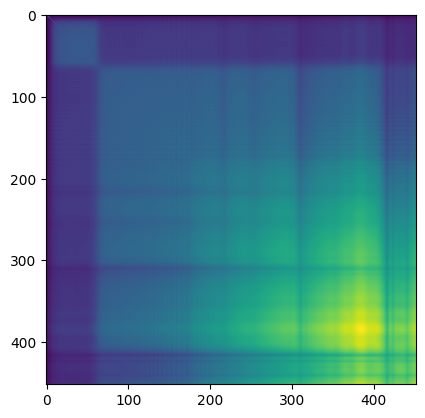

In [13]:
plt.imshow(C)

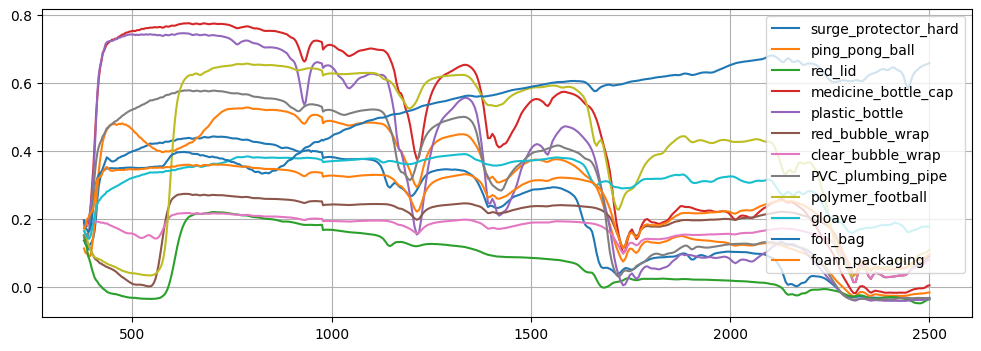

In [14]:
class_names = list(groundtruth_classes.keys())
plt.figure(figsize=(12,4))
for i in range(nClasses):
    plt.plot(wl, class_means[i,:], label=class_names[i])
plt.grid(True)
plt.legend()

In [15]:
im.nbands

452

In [16]:
Cinv = np.linalg.inv(C)

In [17]:
# Compute Mahalanobis Distance to mean for each class, for all pixels
imList_demean = np.zeros((im.nrows*im.ncols,im.nbands))
MD_all = np.zeros((im.nrows*im.ncols, nClasses))

for class_idx in range(nClasses):
    # demean each pixel
    mu = class_means[class_idx,:].flatten()
    for i in range(im.nbands):
        imList_demean[:,i] = imList[:,i] - mu[i]

    MDs_part_1 = np.matmul(imList_demean, Cinv) 
    MDs = np.sum(MDs_part_1 * imList_demean, axis=1)
    MD = np.sqrt(MDs)
    MD_all[:,class_idx] = MD

In [18]:
LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (im.nrows,im.ncols))

Text(0.5, 1.0, 'LDA Class Predictio n Image')

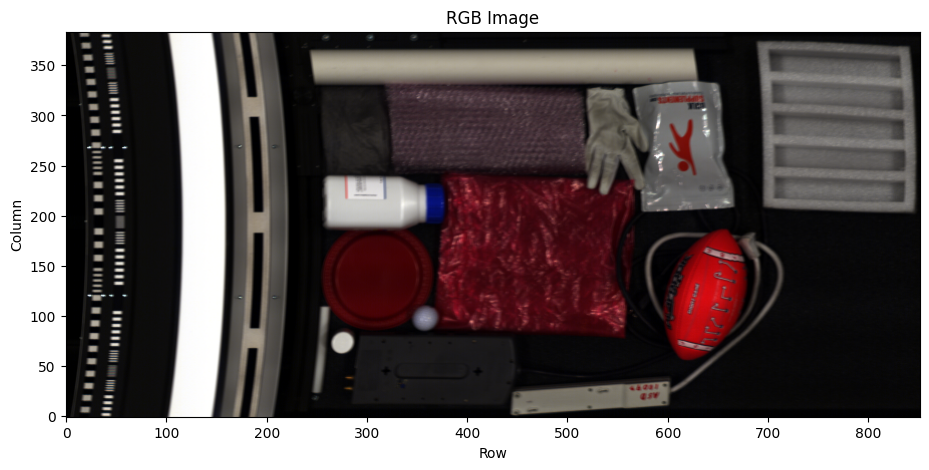

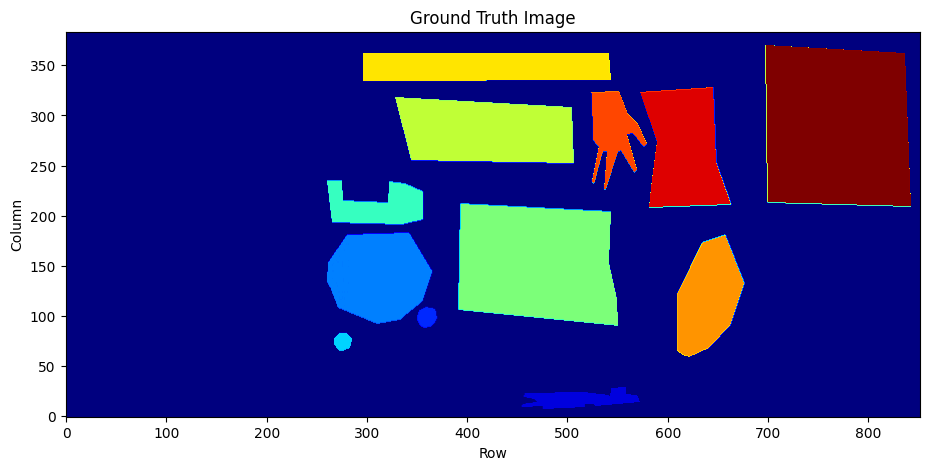

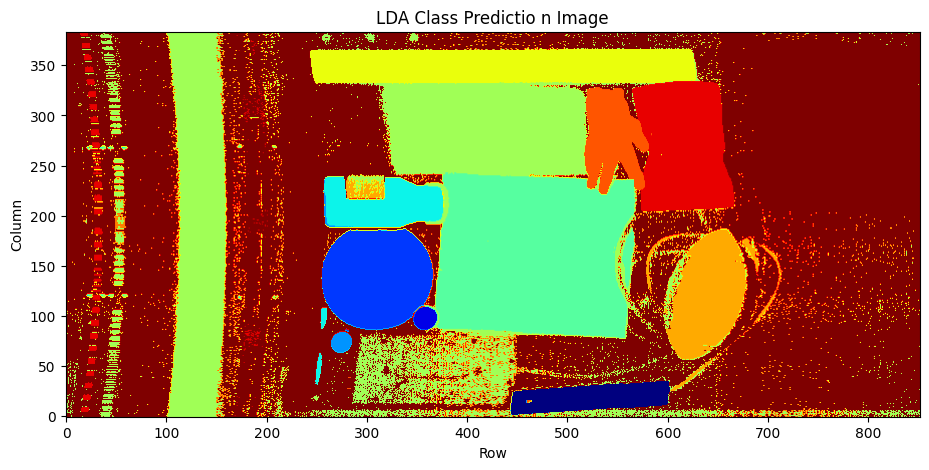

In [19]:
sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(LDA_class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Predictio n Image')

In [20]:
layers = {
    'Ground Truth': gt_im, 
    'LDA Classification': LDA_class_image
}

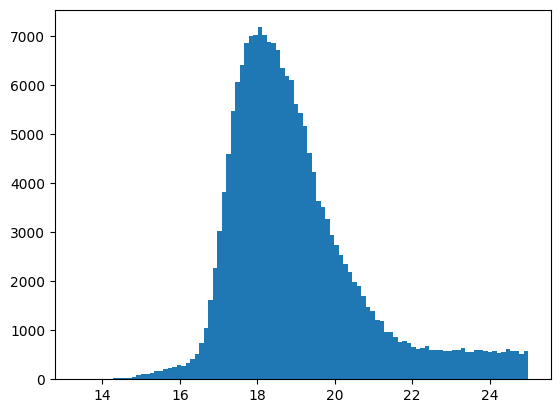

In [21]:
plt.hist(MD[MD<25], bins=100);

In [22]:
import PyQt5
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtGui import *
import pyqtgraph as pg
import numpy as np
import pyqtgraph as pg
import spectral


       

class viewer(QMainWindow):
    def __init__(self, im, layers = {}):
        super().__init__()   
        self.wl = np.asarray(im.bands.centers)
        self.imArr = im.Arr  
        self.layers = layers
        self.nrows = im.Arr.shape[0]
        self.ncols = im.Arr.shape[1]
        self.nbands = im.Arr.shape[2]    
        # compute and set the geometry (shape and location) of the window
        self.computeGeometry()
        self.setGeometry(40, 40, int(self.w), int(self.h))  #loc_x, loc_y, width, height  
        # create the display window with the image
        self.show_RGB()  
        # set plot information
        self.colors = ['r', 'b','g','c','m','y', 'w'] # colors to iterate through for plotting spectra - (can be modified with any colors - see https://pyqtgraph.readthedocs.io/en/latest/_modules/pyqtgraph/functions.html#mkColor for options)

        # Create central widget
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        # Create buttons from the inpout layers
        self.setLayerButtons()
        # Add stretch and band-scrolling button
        self.layout_top_menu.addStretch(1)
        self.layout_top_menu.addWidget(self.buttonViewBands)
        # Create a layout withe the buttons layout with image layout below
        self.layout_main = QVBoxLayout(self)
        self.layout_main.addLayout(self.layout_top_menu)
        self.layout_main.addWidget(self.imv)
        self.central_widget.setLayout(self.layout_main)
        
        # Remove border around image
        self.layout_main.setContentsMargins(0, 0, 0, 0)
        self.central_widget.setContentsMargins(0, 0, 0, 0)
        self.layout_main.setSpacing(0)
         
        # Set events
        self.imv.getImageItem().mouseClickEvent = self.click # create a spectral plot window if the image is clicked on
        
        # Show the Pyt widgets and execute the qtgraph widgets
        self.show() 
        pg.exec() 
    
    def computeGeometry(self):
        aspect_ratio = self.nrows/self.ncols
        if aspect_ratio > 1:
            self.w = 1200
            self.h = self.w/aspect_ratio
        else:
            self.h = 1200
            self.w = aspect_ratio*self.h

    def setLayerButtons(self):        
        self.buttonViewBands = QPushButton('Scroll Bands', self)
        self.buttonViewBands.setMaximumWidth(100)
        self.buttonViewBands.clicked.connect(self.onViewBandsClick)
        self.buttonAnomalyDetection = QPushButton('Anomaly Detection', self)
        self.buttonAnomalyDetection.setMaximumWidth(100)
        self.buttonAnomalyDetection.clicked.connect(self.onButtonAnomalyDetectionClick)
        self.buttonTargetDetection = QPushButton('Target Detection', self)
        self.buttonTargetDetection.setMaximumWidth(100)
        self.buttonTargetDetection.clicked.connect(self.onButtonTargetDetectionClick)
        self.buttonLDA = QPushButton('Classification: LDA', self)
        self.buttonLDA.setMaximumWidth(100)
        self.buttonLDA.clicked.connect(self.onButtonLDAClick)
        # Create a layout area at the top of the central_widget for the buttons
        self.layout_top_menu = QHBoxLayout(self)
        self.layout_top_menu.addWidget(self.buttonAnomalyDetection)
        self.layout_top_menu.addWidget(self.buttonTargetDetection)
        self.layout_top_menu.addWidget(self.buttonLDA)
        
    
    def onViewBandsClick(self):
        self.scrollBandArr = np.swapaxes(np.swapaxes(self.imArr, 0, 2), 1, 2)
        self.imv.setImage(self.scrollBandArr, autoRange=False)
        print('View Bands Button clicked')  

    def onButtonAnomalyDetectionClick(self):
        self.imv.setImage(self.imRGB[:,:,1], autoRange=False)
        print('Anomaly Detection Button clicked')        

    def onButtonTargetDetectionClick(self):
        self.imv.setImage(self.imRGB, autoRange=False)
        print('Target Detection Button clicked')
    
    def onButtonLDAClick(self):
        self.imv.setImage(self.imRGB[:,:,0], autoRange=False)
        print('LDA Button clicked')
        
        
    def show_RGB(self):       
        # create and show an RGB image in the viewer
         
        # determine the indices for the red, green, and blue bands
        self.index_red_band = np.argmin(np.abs(self.wl-650))
        self.index_green_band = np.argmin(np.abs(self.wl-550))
        self.index_blue_band = np.argmin(np.abs(self.wl-460))                
        # Create a numpy array for the RGB image with shape (nrows, ncols, 3)
        self.imRGB =np.zeros((self.nrows,self.ncols,3))
        self.imRGB[:,:,0] = np.squeeze(self.imArr[:,:,self.index_red_band])
        self.imRGB[:,:,1] = np.squeeze(self.imArr[:,:,self.index_green_band])
        self.imRGB[:,:,2] = np.squeeze(self.imArr[:,:,self.index_blue_band])
        # Set the numpy RGB image in the viewer
        self.imv = pg.image(self.imRGB)

    def click(self, event):    
        # plot the spectrum for the clicked pixel location
        
        event.accept()  
        pos = event.pos() # get the position of the event
        x,y = int(pos.x()),int(pos.y()) # get the x,y pixel corrdinates for the location
        print (f'x,y = [{x},{y}]')
        
        # Check if a spectral plot window exists
        try: 
            specPlot_exists = self.specPlot.isVisible() # True if the window has been created and is open. False if it was created and clsoed
        except:
            specPlot_exists = False # If no self.specPlot was created, the 'try' command will go into the 'except' case.
        
        if specPlot_exists:
            self.ci = (self.ci + 1) % len(self.colors) # iterate to the next color
            color = self.colors[self.ci] # select the color
            spec = self.imArr[x,y,:].flatten() # get the selected spectrum from the hyperspectral image
            self.specPlot.plot(self.wl, spec, pen=color, name=f'Pixel [{x},{y}]') # add the new spectrum to the plot
        else:
            self.specPlot = pg.plot()
            self.specPlot.addLegend()
            self.ci = 0 # initialize the color index
            color = self.colors[self.ci] # select the color
            spec = self.imArr[x,y,:].flatten()# get the selected spectrum from the hyperspectral image
            self.specPlot.plot(self.wl, spec, pen=color, name=f'Pixel [{x},{y}]') # create a plot window with the selected spectrum
            self.specPlot.showButtons()
            self.specPlot.showGrid(True, True)
            self.specPlot.setLabels(title='Pixel Spectra', bottom='Wavelength')
            # making the spectral plot window wider
            x = self.specPlot.geometry().x()
            y = self.specPlot.geometry().y()
            w = self.specPlot.geometry().width()
            h = self.specPlot.geometry().height()
            self.specPlot.setGeometry(int(0.5*x), 2*y, 2*w, h)
            self.specPlot.addLegend()



In [23]:
hlv.viewer(im, layers=layers)

NameError: name 'hlv' is not defined